In [1]:
using LinearAlgebra
using Plots
using StaticArrays
using TrajectoryOptimization
import TrajectoryOptimization:dynamics

In [2]:
struct Qubit <: AbstractModel
      n::Int
      m::Int
end

function dynamics(model::Qubit,x,ü)
      #Pauli spin matrices
      i2 = SMatrix{2,2}([0 -1; 1 0]) #2x2 unit imaginary matrix
      # Sx = SMatrix{4,4}([zeros(2,2) I; I zeros(2,2)])
      # Sy = SMatrix{4,4}([zeros(2,2) -i2; i2 zeros(2,2)])
      # Sz = SMatrix{4,4}([I zeros(2,2); zeros(2,2) -I])
      iSx = SMatrix{4,4}([zeros(2,2) i2; i2 zeros(2,2)])
      # iSy = SMatrix{4,4}([zeros(2,2) I; -I zeros(2,2)])
      iSz = SMatrix{4,4}([i2 zeros(2,2); zeros(2,2) -i2])

      u̇ = x[5]
      u = x[6]
      ẋ = [(-iSx - u.*iSz)*x[1:4]; ü; u̇; u]
end

dynamics (generic function with 9 methods)

In [3]:
n = 7 #state dimension
m = 1 #inut dimension
model = Qubit(n,m)

Qubit(7, 1)

In [15]:
dt = 0.01 #time step
N = 101 #number of knot points
tf = dt*(N-1)

x0 = @SVector [1.0, 0, 0, 0, 0, 0, 0] #initial state
xf = @SVector [1/sqrt(2), 0, 1/sqrt(2), 0, 0, 0, 0] #desired final state

U0 = [@SVector randn(m) for k = 1:N-1] #random initial guess for control inputs
X0 = [@SVector fill(NaN,n) for k = 1:N];
Z = Traj(X0,U0,dt*ones(N));

In [22]:
#Set up quadratic objective function
Q = Diagonal(@SVector [1e-3, 1e-3, 1e-3, 1e-3, 1, 1, 1e-3])
R = 10.0*Diagonal(@SVector ones(m))
Qf = 1.0*Diagonal(@SVector ones(n))
obj = LQRObjective(Q,R,Qf,xf,N);

In [23]:
#Set up constriants
goal = GoalConstraint(xf)
con_goal = ConstraintVals(goal, N:N)
conSet = ConstraintSet(n,m,[con_goal], N);

In [24]:
#Set up and solve traj. opt. problem
prob = Problem{RK3}(model, obj, conSet, x0, xf, Z, N, tf)
opts = ALTROSolverOptions{Float64}(verbose=true,projected_newton=false)
solver = ALTROSolver(prob, opts)
solve!(solver)

In [36]:
#Extract states + controls for plotting
X̃ = states(solver)
X = zeros(4,N)
U = zeros(N)
U̇ = zeros(N)
for k = 1:N
      X[:,k] = X̃[k][1:4]
      U[k] = X̃[k][6]
      U̇[k] = X̃[k][5]
end

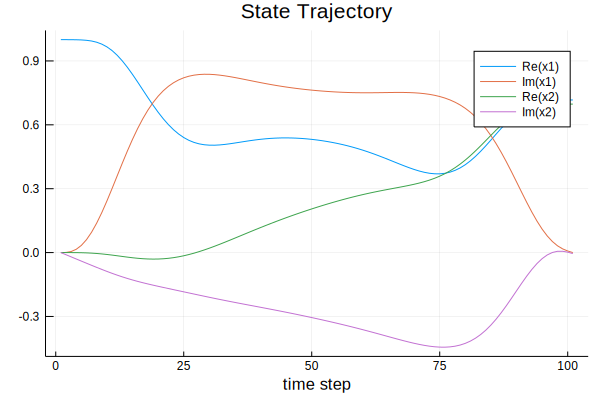

In [38]:
plot(X',xlabel="time step",title="State Trajectory",label=["Re(x1)" "Im(x1)" "Re(x2)" "Im(x2)"])

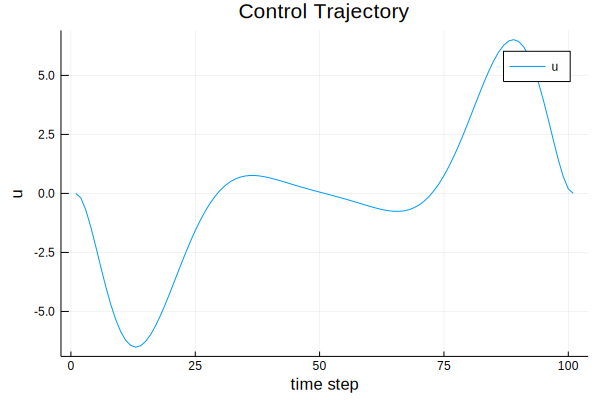

In [27]:
plot(U,xlabel="time step",ylabel="u",title="Control Trajectory",label="u")

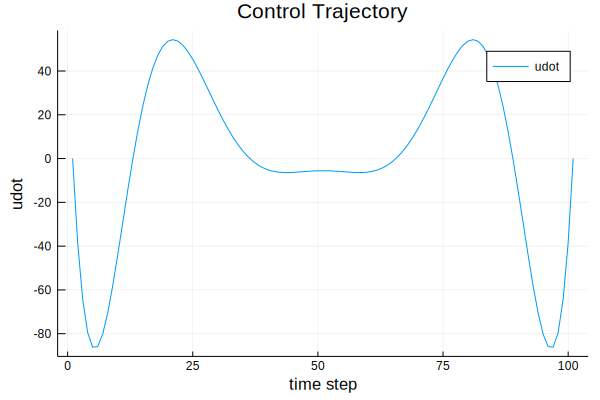

In [12]:
plot(U̇,xlabel="time step",ylabel="udot",title="Control Trajectory",label="udot")